#  This Is My Jam - Data Dump

Andreas Jansson, 2015. gmail: andreas.s.t.jansson

[This Is My Jam](http://www.thisismyjam.com) was an online social music service, founded in London in 2011. It went into read-only [archive mode](http://thisismyjam.tumblr.com/post/126260430022/jam-preserves) in September 2015.

As part of archiving the site we are releasing an [anonymized dump of the final database](https://archive.org/details/thisismyjam-datadump). In this notebook we explore the data from a few different angles to give a sense of possible applications of the data set.

![logo](https://www.thisismyjam.com/includes/image/archives_logo@2x.png?v=2.0) 

## Download the dataset

In [4]:
%%bash
wget --quiet https://archive.org/download/thisismyjam-datadump/thisismyjam-datadump.zip
unzip thisismyjam-datadump.zip

Archive:  thisismyjam-datadump.zip
   creating: archive/
  inflating: archive/followers.tsv   
  inflating: archive/jams.tsv        
  inflating: archive/likes.tsv       


## Load the data

First some imports and helper functions.

In [31]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import collections
import string
import dateutil.parser
from matplotlib import ticker
import json
import datetime

def fuzzy_string(s):
    return s.str.lower().replace('[^a-z]', '', regex=True)

We will use [Pandas](http://pandas.pydata.org/) to analyze the dataset.

In [21]:
jams = pd.read_csv('archive/jams.tsv', sep='\t', header=0,
                   index_col=None, encoding='utf8',
                   escapechar='\\',
                   error_bad_lines=False)

Skipping line 57952: expected 7 fields, saw 8

Skipping line 846714: expected 7 fields, saw 8

Skipping line 1330260: expected 7 fields, saw 8

Skipping line 1543478: expected 7 fields, saw 8

Skipping line 1579152: expected 7 fields, saw 8
Skipping line 1612031: expected 7 fields, saw 8

Skipping line 1784169: expected 7 fields, saw 8



Pandas sometimes has issues with lines with escaped newlines, so we filter bad-looking lines here (there aren't many)

In [22]:
jams = jams[jams['creation_date'].notnull()]
jams = jams[jams['creation_date'].str.startswith('20')]
jams['creation_date'] = pd.to_datetime(jams['creation_date'])

Finally we set the `song_key` for each song to be a naively normalized artist+title. We'll use this later to compare unique songs. For our purposes it's okay to lose a little data and filter jams with empty song_keys.

In [23]:
jams['song_key'] = fuzzy_string(jams['artist'] + jams['title'])
jams = jams[jams['song_key'] != '']
len(jams)

2087522

Next we load likes and followers.

In [16]:
likes = pd.read_csv('archive/likes.tsv', sep='\t', header=0,
                    index_col=None, encoding='utf8',
                    error_bad_lines=False)
len(likes)

5968624

In [19]:
followers = pd.read_csv('archive/followers.tsv', sep='\t', header=0,
                        index_col=None, encoding='utf8',
                        error_bad_lines=False)
len(followers)

1603404

For comparison I crawled YouTube and Billboard Top 100 2011-2015 for the top jams, let's load those datasets too.

In [56]:
%%bash
wget --quiet "https://gist.githubusercontent.com/andreasjansson/0dfa60c3aa9a2cd759a1/raw/11bf3ae9b1dbfc1a6c70d275427fbee888452f80/youtube.txt"
wget --quiet "https://gist.githubusercontent.com/andreasjansson/f105e98c911f0634edcb/raw/93259edcb040c76ca4fdc2bb7d95ac0df4715cf5/billboard.json"

In [55]:
with open('billboard.json') as f:
    raw = json.load(f)
data = []
for chart in raw:
    for song in chart['songs']:
        date = dateutil.parser.parse(chart['date'])
        data.append([date, song['artist'], song['title'], song['position']])
billboard = pd.DataFrame(data, columns=['date', 'artist', 'title', 'position'])
billboard['song_key'] = fuzzy_string(billboard['artist'].replace(' feat.+$', '', regex=True) + billboard['title'])

def get_billboard_top_position(df):
    top_row = df[df['position'] == np.min(df['position'])].iloc[0]
    return '%s (%s)' % (top_row['position'], top_row['date'].strftime('%Y-%m-%d'))

billboard_top_positions = (billboard
                           .groupby('song_key')
                           .apply(get_billboard_top_position)
                           .reset_index())
billboard_top_positions.columns = ['song_key', 'billboard_top_position']

In [61]:
data = {}
with open('youtube.txt') as f:
    for line in f:
        song_key, youtube_plays = line.strip().split()
        data[song_key] = int(youtube_plays)
youtube = pd.DataFrame([{'song_key': song_key, 'youtube_plays': youtube_plays}
                        for song_key, youtube_plays in data.iteritems()])

It's also interesting to look at which jams were active during a particular day, not just jams posted. We generate that data and store it in `daily_jams`.

In [27]:
JAM_END_DATE = dateutil.parser.parse('2015-09-26')

def fill_prev_dates(data, next_date, prev_date, prev_row):
    if prev_date is not None:
        cur_date = prev_date
        end_date = prev_date + datetime.timedelta(days=7)
        while True:
            cur_date += datetime.timedelta(days=1)
            prev_row = prev_row.copy()
            if cur_date >= next_date or cur_date >= end_date:
                break
            prev_row['creation_date'] = cur_date
            data.append(prev_row)

def fill_dates(df):
    data = []
    prev_row = None
    prev_date = None
    for row in df.to_dict('records'):
        fill_prev_dates(data, row['creation_date'], prev_date, prev_row)
        data.append(row)
        prev_date = row['creation_date']
        prev_row = row
    fill_prev_dates(data, JAM_END_DATE, prev_date, prev_row)
    return pd.DataFrame(data)

daily_jams = jams.groupby('user_id').apply(fill_dates)

We'll save a view of the jams joined with likes as `jams_with_likes`, and that grouped by `song_key` as `songs`.

In [52]:
likes_per_jam = (likes
                 .groupby('jam_id')['user_id']
                 .count()
                 .reset_index()
                 .rename(columns={'user_id': 'num_likes'}))
jams_with_likes = jams.merge(likes_per_jam, on='jam_id', how='left')
jams_with_likes['num_likes'].fillna(0, inplace=True)

In [94]:
def get_songs(jams_with_likes):
    return (jams_with_likes
            .groupby('song_key')
            .agg({'jam_id': 'count',
                  'num_likes': 'sum',
                  'artist': 'first',
                  'title': 'first'})
            .reset_index()
            .rename(columns={'jam_id': 'num_jams'}))
songs = get_songs(jams_with_likes)
len(songs)

700591

![logo](https://www.thisismyjam.com/includes/image/archives_logo@2x.png?v=2.0) 

## Basic statistics

First, a utility function to graph multiple lines with a logarithmic Y-axis.

In [33]:
def log_graph(x, xlabel=None, ylabel=None):
    plt.plot(x)
    plt.yscale('log')
    plt.axes().yaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))
    min_x = np.min(x)
    max_x = np.max(x)
    if min_x == 0:
        min_x = 0.1
    plt.ylim([min_x, max_x])
    if xlabel:
        plt.xlabel(xlabel)
    if ylabel:
        plt.ylabel(ylabel)

### Jams per person

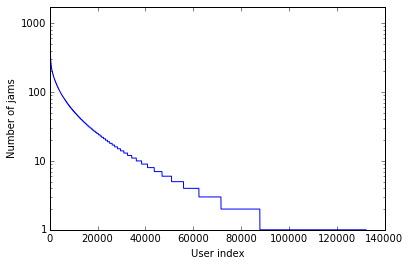

In [34]:
log_graph(jams.groupby('user_id')['jam_id'].count().sort(ascending=False, inplace=False), xlabel='User index', ylabel='Number of jams')

### Likes given per person

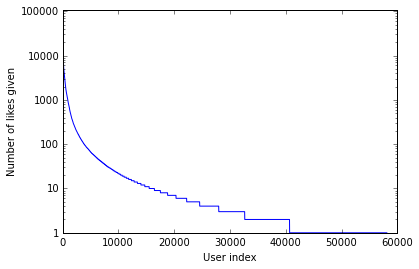

In [42]:
log_graph(likes.groupby('user_id')['jam_id'].count().sort(ascending=False, inplace=False), xlabel='User index', ylabel='Number of likes given')

### Likes per jam

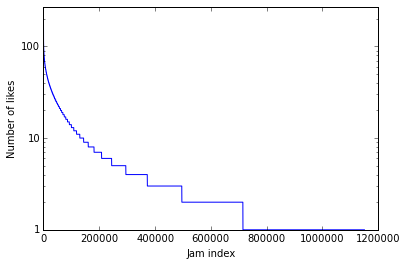

In [43]:
log_graph(likes.groupby('jam_id')['user_id'].count().sort(ascending=False, inplace=False), xlabel='Jam index', ylabel='Number of likes')

### Followers per user

In [44]:
follower_stats = (followers
                  .groupby('follower_user_id')['followed_user_id']
                  .count()
                  .reset_index()
                  .merge(followers
                         .groupby('followed_user_id')['follower_user_id']
                         .count()
                         .reset_index(),
                         left_on='follower_user_id', right_on='followed_user_id', how='outer'))
follower_stats['user_id'] = follower_stats['follower_user_id_x']
follower_stats.loc[follower_stats['user_id'].isnull(), 'user_id'] = follower_stats[follower_stats['user_id'].isnull()]['followed_user_id_y']
follower_stats.drop(['follower_user_id_x', 'followed_user_id_y'], axis=1, inplace=True)
follower_stats.rename(columns={'follower_user_id_y': 'num_followers', 'followed_user_id_x': 'num_followed'}, inplace=True)
follower_stats.fillna(0, inplace=True)
follower_stats['ratio'] = (follower_stats['num_followers'] + 1) / (follower_stats['num_followed'] + 1)
follower_stats.columns

Index([u'num_followed', u'num_followers', u'user_id', u'ratio'], dtype='object')

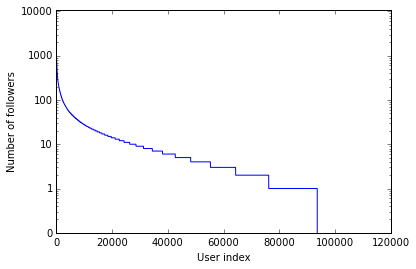

In [47]:
log_graph(follower_stats['num_followers'].sort(ascending=False, inplace=False), xlabel='User index', ylabel='Number of followers')

### Number of users followed per user

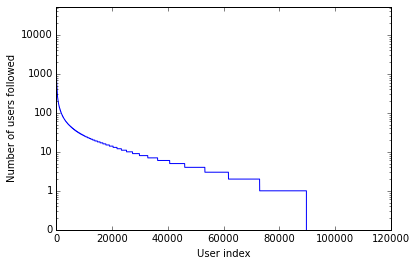

In [49]:
log_graph(follower_stats['num_followed'].sort(ascending=False, inplace=False), xlabel='User index', ylabel='Number of users followed')

### Follower ratio

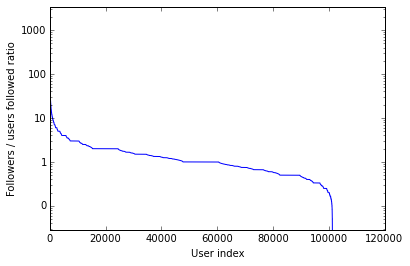

In [50]:
log_graph(follower_stats['ratio'].sort(ascending=False, inplace=False), xlabel='User index', ylabel='Followers / users followed ratio')

![logo](https://www.thisismyjam.com/includes/image/archives_logo@2x.png?v=2.0) 

## Top jams and artists

We'll compare jams to YouTube plays and Billboard chart positions, so we'll merge songs, youtube, and billboard into one `merged_songs` variable.

In [62]:
merged_songs = (songs
                .merge(billboard_top_positions, on='song_key', how='left')
                .merge(youtube, on='song_key', how='left'))
merged_songs.columns

Index([u'song_key', u'title', u'num_likes', u'num_jams', u'artist',
       u'billboard_top_position', u'youtube_plays'],
      dtype='object')

### Most posted jams

In [89]:
merged_songs.sort('num_jams', ascending=False, inplace=False)[:25].reset_index()[['artist', 'title', 'num_jams', 'num_likes', 'billboard_top_position', 'youtube_plays']]

,artist,title,num_jams,num_likes,billboard_top_position,youtube_plays
0,alt-j,Breezeblocks,1070,1277,NaN,70737601
1,Of Monsters And Men,Little Talks,998,967,20 (2013-02-16),158730595
2,Arctic Monkeys,Do I Wanna Know?,874,2771,70 (2014-03-22),217387511
3,Grimes,Oblivion,872,1507,NaN,18441827
4,Lorde,Royals,818,1033,1 (2013-12-07),513468680
5,The Lumineers,Ho Hey,786,741,3 (2013-02-09),134697041
6,Chvrches,The Mother We Share,769,1115,NaN,11418762
7,Gotye,Somebody That I Used To Know,763,593,1 (2012-06-16),685106679
8,Alabama Shakes,Hold On,712,748,93 (2013-03-09),14149362
9,M83,Midnight City,706,1028,72 (2012-04-28),65395649


### Most liked jams

The most liked jams are pretty different to the most posted jams. It appears that users posted modern tracks but liked the "classics".

In [87]:
merged_songs.sort('num_likes', ascending=False, inplace=False)[:25].reset_index()[['artist', 'title', 'num_jams', 'num_likes', 'billboard_top_position', 'youtube_plays']]

,artist,title,num_jams,num_likes,billboard_top_position,youtube_plays
0,Arctic Monkeys,Do I Wanna Know?,874,2771,70 (2014-03-22),217387511
1,Joy Division,Love Will Tear Us Apart,301,2651,NaN,9175639
2,The Rolling Stones,Gimme Shelter,315,2619,NaN,16388778
3,David Bowie,Heroes,436,2615,NaN,4432253
4,Pixies,Where Is My Mind?,487,2587,NaN,2142955
5,The Clash,London Calling,243,2313,NaN,12759845
6,The Who,Baba O'Riley,235,2209,NaN,16928020
7,David Bowie,Life On Mars,366,2120,NaN,17002246
8,Tame Impala,Elephant,644,2061,NaN,9286576
9,Tame Impala,Feels Like We Only Go Backwards,617,2058,NaN,23388025


### Most jammed artists

In [90]:
jams.groupby('artist')['jam_id'].count().sort(ascending=False, inplace=False).reset_index()[:25].rename(columns={'jam_id': 'num_jams'})

,artist,num_jams
0,David Bowie,8143
1,The Beatles,6648
2,Radiohead,6058
3,Daft Punk,4928
4,Arctic Monkeys,4614
5,The Rolling Stones,4331
6,The National,4213
7,Lana Del Rey,3965
8,The Black Keys,3927
9,Led Zeppelin,3876


![logo](https://www.thisismyjam.com/includes/image/archives_logo@2x.png?v=2.0) 

## Jams over time

As a user of This Is My Jam, one often got the sense that songs became popular on the site before they became popular with the general public. To try to quantify this we look at the number of active jams compared to Billboard position.

First, let's look at [Pharrell William's "Happy"](https://www.youtube.com/watch?v=y6Sxv-sUYtM).

In [113]:
def compare_jam_billboard(daily_jams, billboard, song_keys):
    j = daily_jams[daily_jams['song_key'].isin(song_keys)].groupby('creation_date')['jam_id'].count()
    b = billboard[billboard['song_key'].isin(song_keys)]
    b.index = b.date
    b = b['position']

    min_date = min(j.index.min(), b.index.min())
    max_date = max(j.index.max(), b.index.max())
    xlim = [min_date, max_date]
    date_range = pd.date_range(min_date, max_date)

    j = j.reindex(date_range, fill_value=0)

    fig, ax1 = plt.subplots()
    plt.xticks(rotation=30)

    ax1.invert_yaxis()
    line1 = ax1.plot(b.index, b.values, label='Billboard', color='blue')
    ax1.set_ylabel('Billboard position')

    ax2 = ax1.twinx()
    line2 = ax2.plot(j.index, j.values, label='TIMJ', color='red')
    ax2.set_ylabel('Number of active jams')

    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines1 + lines2, labels1 + labels2, loc=0)

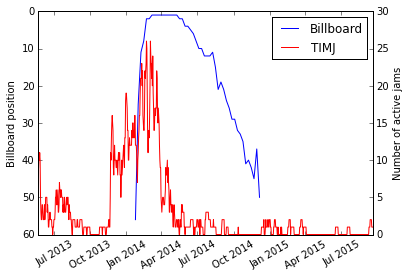

In [114]:
compare_jam_billboard(daily_jams, billboard, ['pharrellhappy', 'pharrellwilliamshappy'])

Next, we can look at ["Shake It Off" by Taylor Swift](https://www.youtube.com/watch?v=nfWlot6h_JM) and see similar results. We also see that tracks stay popular on Billboard longer than on This Is My Jam, where interest fades fairly quickly.

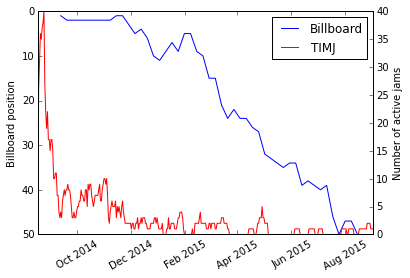

In [115]:
compare_jam_billboard(daily_jams, billboard, ['taylorswiftshakeitoff'])

![logo](https://www.thisismyjam.com/includes/image/archives_logo@2x.png?v=2.0) 

## Indie vs. Mainstream

We can define the mainstreamness of a user as the per-jam average number of users who posted the same song.

In [91]:
songs_by_user = jams.merge(songs, on='song_key').groupby('user_id')
user_mainstreamness = (songs_by_user
                       .agg({'num_jams': 'mean'})
                       .rename(columns={'num_jams': 'mean_jam_popularity'})
                       .reset_index()[['user_id', 'mean_jam_popularity']])

Below is a graph of users ordered by mainstreamness.

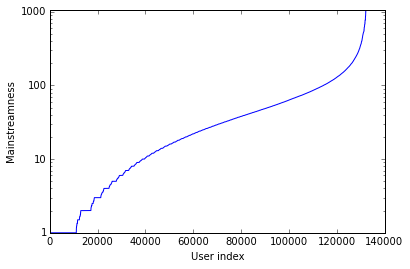

In [93]:
log_graph(user_mainstreamness.sort('mean_jam_popularity', inplace=False)['mean_jam_popularity'], xlabel='User index', ylabel='Mainstreamness')

With this definition of mainstreamness we can compare songs posted by "indie" vs. "mainstream" users. As an example, let us look at the most popular David Bowie songs posted by the least mainstream 33% and most mainstream 33% of users.

In [102]:
def get_artist_tracks_by_user_segment(user_mainstreamness, jams_with_likes, artist, min_mainstream, max_mainstream):
    sorted_users = user_mainstreamness.sort('mean_jam_popularity', inplace=False)
    n = len(sorted_users)
    user_ids = sorted_users[int(n * min_mainstream):int(n * max_mainstream)]['user_id']
    artist_jams = jams_with_likes[(jams_with_likes['artist'].str.lower() == artist.lower()) & jams_with_likes['user_id'].isin(user_ids)]
    artist_songs = get_songs(artist_jams)
    return artist_songs.sort('num_jams', ascending=False, inplace=False).reset_index()[['artist', 'title', 'num_jams']]

Indie Bowie:

In [103]:
get_artist_tracks_by_user_segment(user_mainstreamness, jams_with_likes, 'david bowie', 0, 1/3.)[:10]

,artist,title,num_jams
0,David Bowie,Love Is Lost - Hello Steve Reich Mix by James ...,7
1,David Bowie,Golden Years,6
2,David Bowie,Queen Bitch,6
3,David Bowie,A New Career in a New Town,6
4,David Bowie,Always Crashing In The Same Car,5
5,David Bowie,We Are the Dead,5
6,David Bowie,Subterraneans,4
7,David Bowie,Slip Away,4
8,David Bowie,Cactus,4
9,David Bowie,Boys Keep Swinging,4


Mainstream Bowie:

In [105]:
get_artist_tracks_by_user_segment(user_mainstreamness, jams_with_likes, 'david bowie', 2/3., 1)[:10]

,artist,title,num_jams
0,David Bowie,Heroes,321
1,David Bowie,Life On Mars,238
2,David Bowie,Where Are We Now?,174
3,David Bowie,Space Oddity,144
4,David Bowie,Modern Love,143
5,David Bowie,Starman,101
6,David Bowie,Ashes To Ashes,96
7,David Bowie,Sound And Vision,95
8,David Bowie,Queen Bitch,94
9,David Bowie,Let's Dance,84


One interesting observation from those tables is that the titles on the left-hand side are longer than the titles on the right-hand side. Using our data we can confirm that more popular tracks have shorter song titles. The next graph shows title length ordered by song popularity (with a rolling average of 10,000 jams).

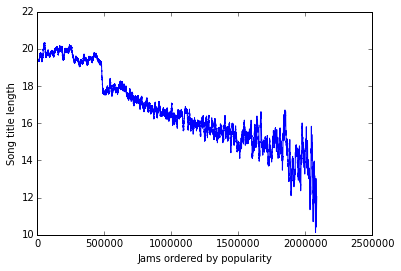

In [106]:
strlen = jams.merge(songs[['song_key', 'num_jams']], on='song_key').sort('num_jams')['title'].str.len()
plt.plot(pd.rolling_mean(strlen[strlen < 100], 10000))
plt.ylabel('Song title length')
plt.xlabel('Jams ordered by popularity')

![logo](https://www.thisismyjam.com/includes/image/archives_logo@2x.png?v=2.0) 

## One-hit-wonders

Let us define the _OneHitWonderness_ of an artist as

$$\textrm{OneHitWonderness}_a = \frac{\sqrt[3]{\sum_i {J_{a, i}}^4}}{\sum_i J_{a, i}}$$

where $a$ is an artist and $J_{a,i}$ is the number of jams for song $i$ by artist $a$.

Using this equation we list the top one hit wonders.

In [110]:
equation = lambda x: (np.sum((x) ** 4.) ** (1/3.)) / np.sum(x)
artist_keys = (songs[~songs['artist'].str.contains('feat')] # filter "X feat. Y"
               .groupby(fuzzy_string(songs['artist']))
               .agg({'num_jams': equation})
               .sort('num_jams', ascending=False)
               .head(10)
               .index.values)
one_hit_wonders = (songs[fuzzy_string(songs['artist']).isin(artist_keys)]
                   .sort('num_jams', ascending=False)
                   .reset_index())
one_hit_wonders[['artist', 'title', 'num_jams']][:10]

,artist,title,num_jams
0,PSY,GANGNAM STYLE,503
1,Solange,Losing You,496
2,Toto,Africa,423
3,College,A Real Hero (feat. Electric Youth),399
4,Redbone,Come And Get Your Love,194
5,Skee-Lo,I Wish,175
6,Q Lazzarus,Goodbye Horses,156
7,White Town,Your Woman,153
8,Ram Jam,BLACK BETTY,145
9,Blue Swede,Hooked On A Feeling,133


Unsurprisingly, [Gangnam Style](https://www.youtube.com/watch?v=9bZkp7q19f0) is the most one-hit-wonder of the past four years.

![logo](https://www.thisismyjam.com/includes/image/archives_logo@2x.png?v=2.0) 

## Seasonal jams

In the next chart we plot active jams over time that have the words "summer" or "christmas" in their titles (normalized, with a rolling average of a week).

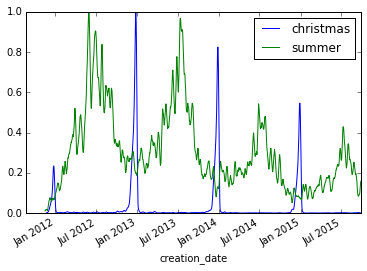

In [117]:
terms = ['christmas', 'summer']
title_string = daily_jams['title'].str.lower().str
for term in terms:
    mask = title_string.contains(term).fillna(False)
    seasonal = daily_jams[mask].groupby('creation_date')['jam_id'].count()
    seasonal = pd.rolling_mean(seasonal, 7)
    seasonal /= np.max(seasonal)
    seasonal.plot(label=term)
plt.legend()

Let us define the _christmasness_ of a song as the number of jams posted between December 1 and December 25, divided by the total number of jams for that song. The following table lists the Jam community’s favorite Christmas songs (ordered by christmasness, with a minimum of 50 jams).

In [119]:
def find_seasonal_jams(jams, songs, min_jams, month, min_day, max_day):
    is_in_season = lambda d: (d.month == month
                              and d.day >= min_day
                              and d.day <= max_day)
    mask = jams['creation_date'].map(is_in_season)
    seasonal = (jams[mask]
                .groupby('song_key')['jam_id']
                .count())
    joined = songs.join(seasonal, on='song_key', how='left').fillna(0)
    joined['ratio'] = joined['jam_id'] / joined['num_jams']
    return (joined[joined['num_jams'] > min_jams]
            .sort(['ratio', 'num_jams'], ascending=False)
            .reset_index())

In [121]:
find_seasonal_jams(jams, songs, 50, 12, 1, 25)[:10][['artist', 'title', 'ratio', 'num_jams']]

,artist,title,ratio,num_jams
0,The Kinks,Father Christmas,0.954545,88
1,Ramones,Merry Christmas (I Don't Want to Fight Tonight),0.945455,55
2,Julian Casablancas,I Wish It Was Christmas Today,0.932203,59
3,Bob Dylan,Must Be Santa,0.923913,92
4,Kate Bush,December Will Be Magic Again,0.921569,51
5,The Darkness,Christmas Time (Don't Let The Bells End),0.919355,62
6,Low,Just Like Christmas,0.918033,183
7,Run-DMC,Christmas In Hollis,0.917722,158
8,Darlene Love,Christmas (Baby Please Come Home),0.914894,94
9,The Waitresses,Christmas Wrapping,0.899038,208


Using the same algorithm we can attempt to find Halloween jams.

In [124]:
find_seasonal_jams(jams, songs, 20, 10, 20, 31)[:10][['artist', 'title', 'ratio', 'num_jams']]

,artist,title,ratio,num_jams
0,Lou Reed,Halloween Parade,0.954545,44
1,Mary J. Blige,Be Without You,0.812500,32
2,Misfits,Halloween,0.740741,27
3,Lady Gaga,Do What U Want (feat. R Kelly),0.735294,34
4,Danny Elfman,This is Halloween,0.695652,23
5,"Bobby ""Boris"" Pickett",Monster Mash,0.692308,26
6,Tracy Jordan,Werewolf Bar Mitzvah,0.666667,30
7,Marilyn Manson,This Is Halloween,0.656250,32
8,Ministry,Everyday Is Halloween,0.612500,80
9,The Weeknd,Enemy,0.580645,31
